### Wczytanie danych z biblioteki TorchVision

In [3]:

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader


# transformacje dla pre-processingu
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        #transforms.Resize((28,28))
        #transforms.CenterCrop(28)
    ]
)

# FashionMNIST dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Data loader
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 39.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### EDA

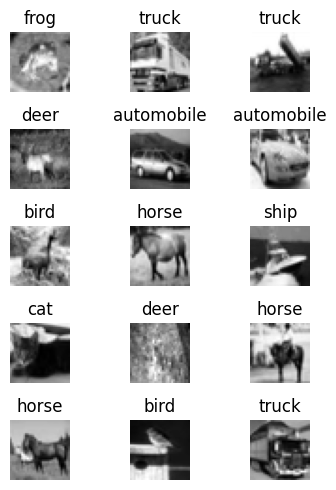

In [4]:
from matplotlib import pyplot as plt
LABELS = {
  0: "airplane",
  1: "automobile",
  2: "bird",
  3: "cat",
  4: "deer",
  5: "dog",
  6: "frog",
  7: "horse",
  8: "ship",
  9: "truck"
}

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(4, 5))
axes = axes.flatten()

for i,(img, label) in enumerate(train_dataset):
  if i >= 15: break

  axes[i].imshow(img[0, :, :], cmap="gray")
  axes[i].axis("off")
  axes[i].set_title(LABELS[label])

plt.tight_layout()
plt.show()

### Definiowane dwóch modeli konwolucyjnych

In [5]:
# WŁASNA SIEĆ NEURONOWA


import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)  # 32x32 -> 30x30
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3) # 30x30 -> 28x28
        # Pooling layer
        self.pool = nn.AvgPool2d(2, 2)  # Pooling: 28x28 -> 14x14 -> 12x12 -> 6x6
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 6 * 6, 128)  # Adjusted for the output size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 30x30 -> 15x15
        x = self.pool(F.relu(self.conv2(x)))  # 15x15 -> 13x13 -> 6x6
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model_custom = CustomCNN()

In [6]:
# RESNET18

from torchvision.models import resnet18, ResNet18_Weights

# Load pre-trained ResNet18
model_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the first convolutional layer for 32x32 input
model_resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)



# Print the modified model for verification
print(model_resnet)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.5MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
print(f"Custom model: {sum(p.numel() for p in model_custom.parameters() if p.requires_grad)} trenowalnych parametrów")


Custom model: 84154 trenowalnych parametrów


In [8]:
print(f"ResNet18: {sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)} trenowalnych parametrów")


ResNet18: 11681832 trenowalnych parametrów


In [9]:
!pip install torchview
from torchview import draw_graph

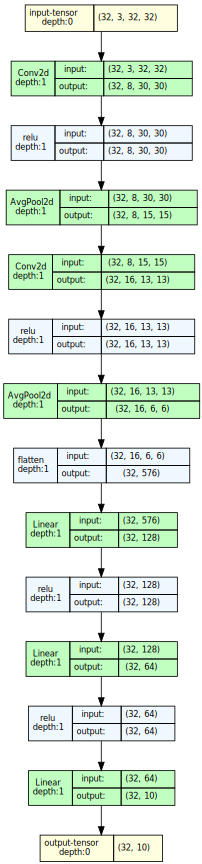

In [19]:
model_visualizer = draw_graph(model_custom, input_size=(batch_size, 3, 32, 32)) # input_size=(batch_size, 1, 28, 28) - rozmiar wejściowy (B, C, H, W)
# na 3 channele, bo kolory, rozmiar zdjęć zjechaliśmy z 32 na 28 więc zostawiamy
model_visualizer.visual_graph

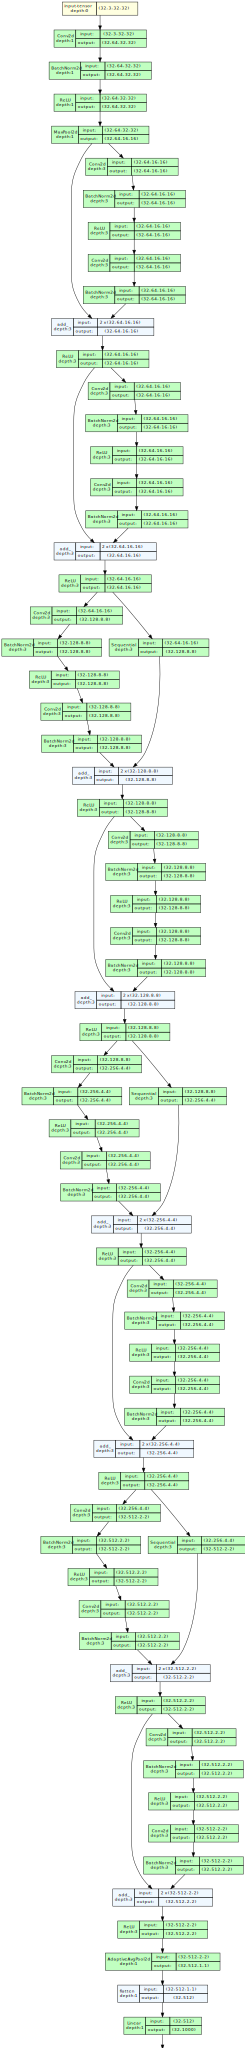

In [20]:
model_visualizer = draw_graph(model_resnet, input_size=(batch_size, 3, 32, 32)) # input_size=(batch_size, 1, 28, 28) - rozmiar wejściowy (B, C, H, W), to samo co wyżej
model_visualizer.visual_graph

### Trening modeli

In [10]:
def plot_loss(train_loss, val_loss, val_accuracy, save_name):

    fig, axes = plt.subplots(ncols=2, figsize=(8, 4))


    axes[0].plot(val_loss, marker='.', label='Validation')
    axes[0].plot(train_loss, marker='.', label='Train')
    axes[1].plot(val_accuracy, marker='.', label='Validation')

    axes[0].legend()
    axes[1].legend()

    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")

    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")

    fig.tight_layout()
    fig.show()

    fig.savefig(save_name, dpi=300, bbox_inches='tight')


In [11]:
from torch import optim
from tqdm import tqdm

def train(model, save_name, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(epochs):

        model.train()
        losses = []

        for i, (inputs, labels) in tqdm(enumerate(train_dataloader, 0),desc=f"[{epoch + 1}/{epochs}] Training"):

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        train_loss.append(np.mean(losses))

        # validation loss
        model.eval()
        losses = []
        correct_preds = 0

        for i, (inputs, labels) in tqdm(enumerate(test_dataloader),desc=f"[{epoch + 1}/{epochs}] Validation"):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            correct_preds += (outputs.argmax(dim=1) == labels).float().mean().item()

        val_accuracy.append(correct_preds/len(test_dataloader))
        val_loss.append(np.mean(losses))

        # print loss
        print(f'\ttrain loss: {train_loss[-1]:.4f} | val loss: {val_loss[-1]:.4f}| val acc.: {val_accuracy[-1]*100.0:.2f}\n')

    torch.save(model.state_dict(), save_name)

    return train_loss, val_loss, val_accuracy

In [13]:
train_loss, val_loss, val_accuracy = train(model_custom, 'model_custom.pth', epochs=10)

[1/10] Training: 1563it [00:37, 42.18it/s]
[1/10] Validation: 313it [00:04, 70.24it/s]


	train loss: 1.5982 | val loss: 1.3886| val acc.: 50.24



[2/10] Training: 1563it [00:34, 45.03it/s]
[2/10] Validation: 313it [00:04, 64.45it/s]


	train loss: 1.3182 | val loss: 1.2612| val acc.: 54.94



[3/10] Training: 1563it [00:34, 45.31it/s]
[3/10] Validation: 313it [00:04, 72.32it/s]


	train loss: 1.1861 | val loss: 1.1970| val acc.: 57.42



[4/10] Training: 1563it [00:33, 46.42it/s]
[4/10] Validation: 313it [00:04, 73.32it/s]


	train loss: 1.0847 | val loss: 1.1473| val acc.: 59.31



[5/10] Training: 1563it [00:33, 46.72it/s]
[5/10] Validation: 313it [00:04, 75.42it/s]


	train loss: 1.0075 | val loss: 1.0731| val acc.: 62.15



[6/10] Training: 1563it [00:33, 46.31it/s]
[6/10] Validation: 313it [00:04, 75.02it/s]


	train loss: 0.9433 | val loss: 1.0852| val acc.: 61.87



[7/10] Training: 1563it [00:33, 47.09it/s]
[7/10] Validation: 313it [00:04, 75.09it/s]


	train loss: 0.8870 | val loss: 1.0589| val acc.: 63.20



[8/10] Training: 1563it [00:33, 47.25it/s]
[8/10] Validation: 313it [00:04, 73.93it/s]


	train loss: 0.8373 | val loss: 1.0691| val acc.: 63.84



[9/10] Training: 1563it [00:31, 48.87it/s]
[9/10] Validation: 313it [00:04, 63.53it/s]


	train loss: 0.7944 | val loss: 1.0477| val acc.: 64.83



[10/10] Training: 1563it [00:32, 48.67it/s]
[10/10] Validation: 313it [00:05, 61.73it/s]

	train loss: 0.7552 | val loss: 1.0733| val acc.: 64.62



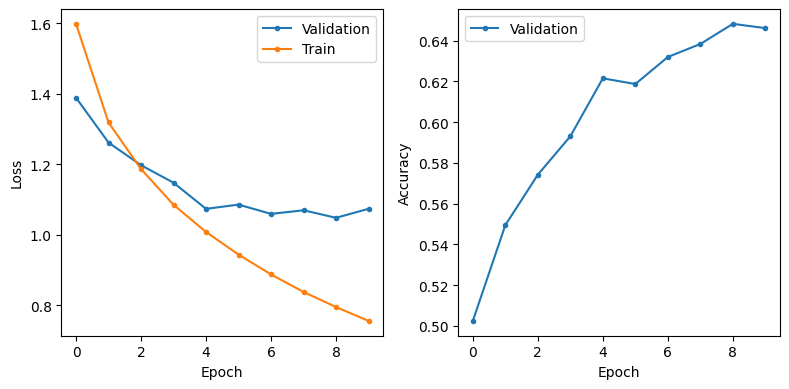

In [14]:
plot_loss(train_loss, val_loss, val_accuracy, 'model_custom.png')

In [15]:
train_loss, val_loss, val_accuracy = train(model_resnet, 'model_resnet.pth', epochs=10)

[1/10] Training: 1563it [25:34,  1.02it/s]
[1/10] Validation: 313it [01:33,  3.35it/s]


	train loss: 1.1817 | val loss: 0.7970| val acc.: 72.71



[2/10] Training: 1563it [25:30,  1.02it/s]
[2/10] Validation: 313it [01:33,  3.34it/s]


	train loss: 0.7025 | val loss: 0.6205| val acc.: 78.69



[3/10] Training: 1563it [25:34,  1.02it/s]
[3/10] Validation: 313it [01:32,  3.39it/s]


	train loss: 0.5608 | val loss: 0.6336| val acc.: 78.43



[4/10] Training: 1563it [25:17,  1.03it/s]
[4/10] Validation: 313it [01:32,  3.40it/s]


	train loss: 0.4557 | val loss: 0.5274| val acc.: 82.38



[5/10] Training: 1563it [24:51,  1.05it/s]
[5/10] Validation: 313it [01:26,  3.61it/s]


	train loss: 0.3496 | val loss: 0.5472| val acc.: 82.13



[6/10] Training: 1563it [25:52,  1.01it/s]
[6/10] Validation: 313it [01:29,  3.51it/s]


	train loss: 0.2780 | val loss: 0.5059| val acc.: 83.95



[7/10] Training: 1563it [24:56,  1.04it/s]
[7/10] Validation: 313it [01:27,  3.56it/s]


	train loss: 0.1957 | val loss: 0.5841| val acc.: 82.51



[8/10] Training: 1563it [25:35,  1.02it/s]
[8/10] Validation: 313it [01:32,  3.39it/s]


	train loss: 0.1594 | val loss: 0.6148| val acc.: 83.00



[9/10] Training: 1563it [25:47,  1.01it/s]
[9/10] Validation: 313it [01:34,  3.33it/s]


	train loss: 0.1213 | val loss: 0.6246| val acc.: 83.05



[10/10] Training: 1563it [26:31,  1.02s/it]
[10/10] Validation: 313it [01:33,  3.36it/s]


	train loss: 0.1078 | val loss: 0.6890| val acc.: 81.29



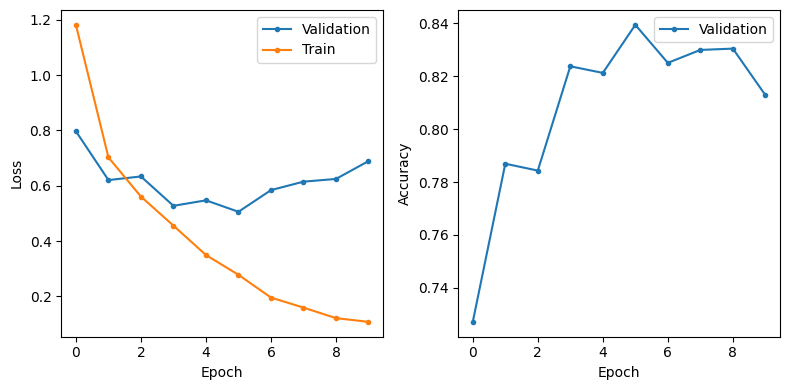

In [16]:
plot_loss(train_loss, val_loss, val_accuracy, 'model_resnet.png')

In [10]:
del model_custom, model_resnet

"Jeszcze jedna epoka ..." - zagadnienie przetrenowania modeli

<img src="https://github.com/Kacper-Marciniak/Kurs-AI/blob/main/Student/P5/model_overfitting.png?raw=1" alt="overfitting" width="75%"/>

### Walidacja modelu na zbiorze testowym

In [17]:
# 1.6. Czytanie modelu

model_custom = CustomCNN()
model_resnet = resnet18()
model_resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

model_custom.load_state_dict(torch.load("model_custom.pth", weights_only=True))
model_resnet.load_state_dict(torch.load("model_resnet.pth", weights_only=True))

<All keys matched successfully>

In [18]:
# Prosta ewaluacja - ACCURACY / DOKŁADNOŚĆ modelu (globalna)

def evaluate(model):
    correct_preds = 0

    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:
            correct_preds += (model(images).argmax(dim=1) == labels).float().mean().item()

    accuracy = correct_preds * 100 / len(test_dataloader)

    print(f'Global accuracy on test set: {accuracy:.2f}%')

In [19]:
print("Custom model:")
evaluate(model_custom)

Custom model:
Global accuracy on test set: 64.62%


In [20]:
print("ResNet18:")
evaluate(model_resnet)

ResNet18:
Global accuracy on test set: 81.29%


In [21]:
# Confusion matrix / macierz pomyłek
# Jak model radzi sobie z poszczególnymi klasami

def confusion_matrix(model, n_classes=10):
    matrix = np.zeros((n_classes, n_classes),dtype=int)

    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:

            predicted = torch.max(model(images).data, 1)[1]

            for p,l in zip(predicted, labels):
                p,l = p.item(), l.item()
                matrix[p,l] += 1

    return matrix

In [22]:
matrix_custom = confusion_matrix(model_custom)

In [23]:
matrix_resnet = confusion_matrix(model_resnet)

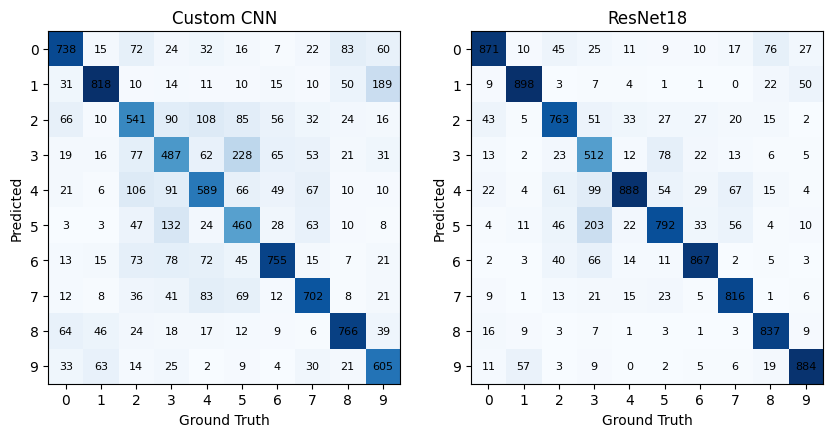

In [24]:

fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(matrix_custom, cmap='Blues')
ax[0].set_title("Custom CNN")
ax[0].set_xticks(list(LABELS.keys()))
ax[0].set_yticks(list(LABELS.keys()))

ax[0].set_ylabel("Predicted")
ax[0].set_xlabel("Ground Truth")

for i in range(10):
    for j in range(10):
        ax[0].text(j, i, matrix_custom[i, j], ha="center", va="center", color="black", fontsize=8)


ax[1].imshow(matrix_resnet, cmap='Blues')
ax[1].set_title("ResNet18")
ax[1].set_xticks(list(LABELS.keys()))
ax[1].set_yticks(list(LABELS.keys()))

ax[1].set_ylabel("Predicted")
ax[1].set_xlabel("Ground Truth")

for i in range(10):
    for j in range(10):
        ax[1].text(j, i, matrix_resnet[i, j], ha="center", va="center", color="black", fontsize=8)

plt.show()

In [25]:
# Analiza macierzy pomyłek
# Wyznaczenie metryk dla poszczególnych klas
# Wyznaczenie metryk globalnych - uśrednienie po klasach

def analyze_matrix(matrix):
    global_res = {"accuracy": np.zeros(matrix.shape[0]), "precision": np.zeros(matrix.shape[0]), "recall": np.zeros(matrix.shape[0]), "f1": np.zeros(matrix.shape[0])}
    for i,c in LABELS.items():
        print(f'{c}:')
        tp = matrix[i,i]
        fp = np.sum(matrix[i,:]) - tp
        fn = np.sum(matrix[:,i]) - tp
        tn = np.sum(matrix) - tp - fp - fn

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)
        accuracy = (tp+tn) / (tp+fp+fn+tn)

        global_res["accuracy"][i] = accuracy
        global_res["precision"][i] = precision
        global_res["recall"][i] = recall
        global_res["f1"][i] = f1

        print(f'\taccuracy: {accuracy*100.0:.2f}, precision: {precision*100.0:.2f}, recall: {recall*100.0:.2f}, F1: {f1*100.0:.2f}')

    print(f'-------------\nGlobal (macro) results:')
    print(f'\taccuracy: {np.mean(global_res["accuracy"])*100.0:.2f}, precision: {np.mean(global_res["precision"])*100.0:.2f}, recall: {np.mean(global_res["recall"])*100.0:.2f}, F1: {np.mean(global_res["f1"])*100.0:.2f}')




In [26]:
analyze_matrix(matrix_custom)

airplane:
	accuracy: 94.07, precision: 69.04, recall: 73.80, F1: 71.34
automobile:
	accuracy: 94.78, precision: 70.64, recall: 81.80, F1: 75.81
bird:
	accuracy: 90.54, precision: 52.63, recall: 54.10, F1: 53.35
cat:
	accuracy: 89.15, precision: 45.99, recall: 48.70, F1: 47.30
deer:
	accuracy: 91.63, precision: 58.03, recall: 58.90, F1: 58.46
dog:
	accuracy: 91.42, precision: 59.13, recall: 46.00, F1: 51.74
frog:
	accuracy: 94.16, precision: 69.01, recall: 75.50, F1: 72.11
horse:
	accuracy: 94.12, precision: 70.77, recall: 70.20, F1: 70.48
ship:
	accuracy: 95.31, precision: 76.52, recall: 76.60, F1: 76.56
truck:
	accuracy: 94.04, precision: 75.06, recall: 60.50, F1: 67.00
-------------
Global (macro) results:
	accuracy: 92.92, precision: 64.68, recall: 64.61, F1: 64.42


In [27]:
analyze_matrix(matrix_resnet)

airplane:
	accuracy: 96.41, precision: 79.11, recall: 87.10, F1: 82.91
automobile:
	accuracy: 98.01, precision: 90.25, recall: 89.80, F1: 90.03
bird:
	accuracy: 95.40, precision: 77.38, recall: 76.30, F1: 76.84
cat:
	accuracy: 93.38, precision: 74.64, recall: 51.20, F1: 60.74
deer:
	accuracy: 95.33, precision: 71.44, recall: 88.80, F1: 79.18
dog:
	accuracy: 94.03, precision: 67.06, recall: 79.20, F1: 72.63
frog:
	accuracy: 97.21, precision: 85.59, recall: 86.70, F1: 86.14
horse:
	accuracy: 97.22, precision: 89.67, recall: 81.60, F1: 85.45
ship:
	accuracy: 97.85, precision: 94.15, recall: 83.70, F1: 88.62
truck:
	accuracy: 97.72, precision: 88.76, recall: 88.40, F1: 88.58
-------------
Global (macro) results:
	accuracy: 96.26, precision: 81.80, recall: 81.28, F1: 81.11
